In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, RepeatVector, TimeDistributed, Dense
)
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
PROJECT_ROOT = Path.cwd().parent
base = PROJECT_ROOT / "data/raw/hdfs/HDFS_v1/preprocessed"

traces = pd.read_csv(base / "Event_traces.csv")
labels_df = pd.read_csv(base / "anomaly_label.csv")

labels = labels_df["Label"].map({"Normal": 0, "Anomaly": 1}).values

print("Traces shape:", traces.shape)
print("Labels shape:", labels.shape)


Traces shape: (575061, 6)
Labels shape: (575061,)


In [6]:
# Parse Features column manually (robust)
parsed_sequences = traces["Features"].apply(
    lambda s: [int(e.strip()[1:]) for e in s.strip("[]").split(",")]
)

parsed_sequences.head()


0    [5, 22, 5, 5, 11, 11, 9, 9, 11, 9, 26, 26, 26,...
1    [5, 5, 22, 5, 11, 9, 11, 9, 11, 9, 26, 26, 26,...
2    [5, 22, 5, 5, 11, 9, 11, 9, 11, 9, 3, 26, 26, ...
3    [5, 22, 5, 5, 11, 9, 11, 9, 11, 9, 26, 26, 26,...
4    [5, 5, 22, 5, 11, 9, 11, 9, 11, 9, 26, 26, 26,...
Name: Features, dtype: object

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 20

sequences = pad_sequences(
    parsed_sequences,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

print("Sequences shape:", sequences.shape)

Sequences shape: (575061, 20)


In [8]:
VOCAB_SIZE = int(sequences.max()) + 1
print("Vocabulary size:", VOCAB_SIZE)

Vocabulary size: 30


In [9]:
X_train = sequences[labels == 0]
X_test = sequences
y_test = labels

print("Train sequences:", X_train.shape)
print("Test sequences:", X_test.shape)

Train sequences: (558223, 20)
Test sequences: (575061, 20)


In [10]:
EMBED_DIM = 32
LATENT_DIM = 64
BATCH_SIZE = 256
EPOCHS = 20

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, RepeatVector, TimeDistributed, Dense
)
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(MAX_LEN,))

x = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBED_DIM
)(inputs)

encoded = LSTM(LATENT_DIM, activation="tanh")(x)

decoded = RepeatVector(MAX_LEN)(encoded)
decoded = LSTM(EMBED_DIM, activation="tanh", return_sequences=True)(decoded)

outputs = TimeDistributed(
    Dense(VOCAB_SIZE, activation="softmax")
)(decoded)

model = Model(inputs, outputs)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy"
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 20, 32)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 30)         │           990 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,198 (153.12 KB)

 Trainable params: 39,198 (153.12 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
X_train_in = X_train
X_train_out = X_train[..., np.newaxis]

In [13]:
early_stop = EarlyStopping(
    monitor="loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_in,
    X_train_out,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True
)

Epoch 1/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 0.5886
Epoch 2/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.1691
Epoch 3/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0798
Epoch 4/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - loss: 0.0433
Epoch 5/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 0.0422
Epoch 6/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.0252
Epoch 7/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - loss: 0.0149
Epoch 8/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0196
Epoch 9/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0094
Epoch 10/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0128
Epoch 11/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - loss: 0.0061
Epoch 12/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - loss: 0.0109
Epoch 13/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0043
Epoch 14/20
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.0077
E

In [14]:
recon = model.predict(X_test, batch_size=BATCH_SIZE)

recon_ids = recon.argmax(axis=-1)

reconstruction_error = np.mean(
    recon_ids != X_test,
    axis=1
)

print("Reconstruction error shape:", reconstruction_error.shape)


2247/2247 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step
Reconstruction error shape: (575061,)


In [15]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, reconstruction_error)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9210548758753564


In [16]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary"
)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Precision: 0.8047
Recall:    0.8455
F1-score:  0.8246
Confusion Matrix:
[[554769   3454]
 [  2602  14236]]


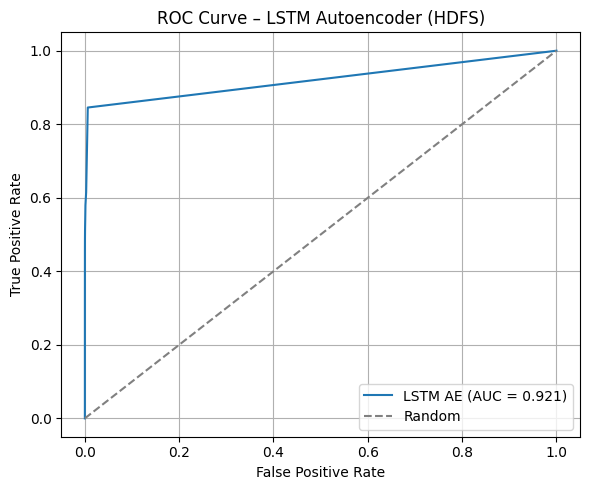

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LSTM AE (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LSTM Autoencoder (HDFS)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

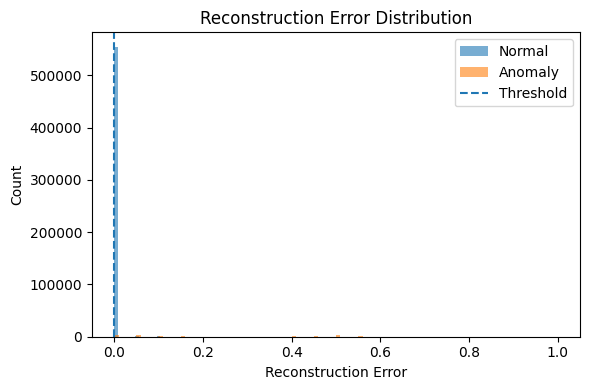

In [18]:
plt.figure(figsize=(6,4))
plt.hist(
    reconstruction_error[y_test == 0],
    bins=100,
    alpha=0.6,
    label="Normal"
)
plt.hist(
    reconstruction_error[y_test == 1],
    bins=100,
    alpha=0.6,
    label="Anomaly"
)

plt.axvline(threshold, linestyle="--", label="Threshold")

plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.tight_layout()
plt.show()


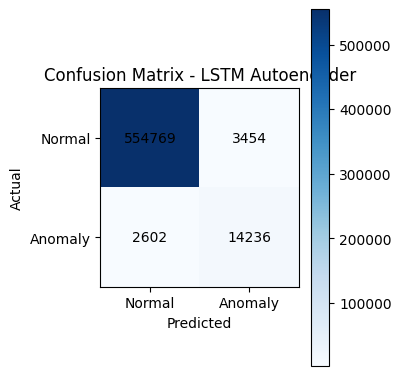

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black")

plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.yticks([0, 1], ["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM Autoencoder")
plt.tight_layout()
plt.show()
